<h1><center><font size="6">Predicting Telco Customer Churn</font></center></h1>

<h2><center><font size="4">Dataset used:Private </font></center></h2>

<a id="top"></a> <br>
## Table of Contents
1. [Introduction](#1)

1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate](#3)
    
1. [Hyperparam Tuning - Multiple Classifiers](#4)
    1. [Data Prep](#41)
        1. [Memory Footprint Reduction](#411)
        1. [Train Test Split](#412)
        1. [Upsampling CV Train fold](#413)
    1. [Tuning Prep](#42)
        1. [Instantiate Classifiers](#421)
        1. [Define Hyperparam Search Space](#422)
            1. [Random Forest](#4221)
            1. [Extra Trees](#4222)
            1. [Gradient Boosting](#4223)
            1. [LightGBM](#4224)
            1. [XGBoost](#4225)
    1. [GridSearchCV](#43)

1. [Create Ensemble - Voting Classifier](#5)
    1. [Check out individual models](#51)
    1. [Initialize Base Classifiers](#52)
    1. [Fit Voting Classifier](#53)
    1. [Test Performance](#54)
    
1. [Conclusion](#6)

1. [References](#7)

# <a id='1'>Introduction</a>  

Based on the original data, we will attempt to make the predictions more accurate by ensembling the results from several tuned models


# <a id='2'>Initialization</a>  

## <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os

import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") # Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Churn'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No', 'Yes']

input_file_name =  'WA_Fn-UseC_-Telco-Customer-Churn.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day1_cleaned_df_output_20200501.pkl'

# output_df_file_name = 'week4_cleaned_df_output_' 
tuned_ensemble_params_name = 'day5_grid_search_ensemble_params_'

# Enter the date in which this notebook is run
export_date = '20200514'

In [3]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
import os
print(os.listdir('../input'))
# This will list all the files in this folder

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


## <a id='3'>Load Data & Validate</a>  

In [4]:
df = pd.read_csv('../input/' + input_file_name)
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3266,0464-WJTKO,Female,0,Yes,Yes,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.10,1460.85,No
926,7074-IEVOJ,Female,1,No,No,3,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,79.40,205.05,Yes
5544,9572-MTILT,Male,0,Yes,No,59,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,106.75,6252.9,Yes
3980,8868-WOZGU,Male,0,No,No,28,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,105.70,2979.5,Yes
2766,1229-RCALF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,115.00,7396.15,No


Lets check the head & tail to make sure there is nothing going on

In [5]:
df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
df.tail(3)
# similar logic here

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


No data corruption seen in either the head or the tail

### <a id = 31> Import cleaned dataframe

In [7]:
import pickle

infile = open(clean_df_file_name,'rb')
clean_df = pickle.load(infile)
infile.close()


## <a id='4'>Hyperparam Tuning - Multiple Classifiers

### <a id=41> Data Prep 

#### <a id='411'>Memory Footprint Reduction

In [8]:
from helper_functions_comprehensive import reduce_mem_usage_function
clean_df, NAlist = reduce_mem_usage_function(clean_df)

# Always reduce the dataset right after loading 
#even if you are sure that when exporting it you have reduced it
# This is because Pandas inflates the size of the data

Memory usage of dataframe is 1.13 MB
Column gender dtype after is float32 
******************************
Column SeniorCitizen dtype after is float32 
******************************
Column Partner dtype after is float32 
******************************
Column Dependents dtype after is float32 
******************************
Column tenure dtype after is float32 
******************************
Column PhoneService dtype after is float32 
******************************
Column MultipleLines dtype after is float32 
******************************
Column InternetService dtype after is float32 
******************************
Column OnlineSecurity dtype after is float32 
******************************
Column OnlineBackup dtype after is float32 
******************************
Column DeviceProtection dtype after is float32 
******************************
Column TechSupport dtype after is float32 
******************************
Column StreamingTV dtype after is float32 
*****************************

#### <a id=412 > Data Splitting

#### Feature - Target split

In [9]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]

##### Train - Test Split

In [10]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 5625 | positives in y (train): 1495.0
Length of (test): 1407 | positives in y (test): 374.0


#### <a id=413 > Upsampling Train CV Fold

In [11]:
from imblearn.combine import SMOTEENN

# Keep a holdout set that has not been upsampled
cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify=y_train)

# Call our upsampling function or you can use any of the imblearn packages here
X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

### <a id=42> Tuning Prep

#### <a id=421> Instantiate classifiers

In [20]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [13]:
from collections import Counter
# Store the fitted models in a dictionary to be called in a subsequent subroutine
classifier_dict = Counter()

classifier_dict['Random_Forest'] = RandomForestClassifier
classifier_dict['Extra_Tree'] = ExtraTreesClassifier
classifier_dict['Gradient_Boosting'] = GradientBoostingClassifier

classifier_dict['Light_GBM'] = LGBMClassifier
classifier_dict['XGBoost'] = XGBClassifier



Link to a brief comparison among different Gradient Boosting based algorithms 
https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb

#### <a id='422'>Define Hyperparam Search Space</a> 

In [14]:
# Use this to manually store the search space
hyper_param_space_dict = Counter()

##### <a id='4221'>Random Forest</a> 

In [15]:
# Create search space
hyper_param_space_dict['Random_Forest'] = {
    
            'random_state': [42],
            'warm_start':[True],
    
            'n_estimators':[50, 100, 200, 400],
            'max_depth': [5, 6, 7, 8, 9, 10, 11],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10, 20, 50] ,

                                          }

##### <a id='4222'>Extra Tree</a> 

Extremely Randomized Trees have even the splits being randomized unlike RF where the feature splits are deterministic
Also, unlike RF, sampling happens without replacement (ie Bootstrapping = False on average)
ET have better performance in the presence of noisy features vs RF
When all the variables are equally important, then it doesnt matter what you use
https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/


In [16]:
hyper_param_space_dict['Extra_Tree'] = {
    
            'random_state': [42],
            'warm_start':[True],
    
            'n_estimators':[100, 200],
            'max_depth': [5, 6, 7, 8, 9, 10, 11],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10, 20, 50] , 
        }

##### <a id='4223'>Gradient Boosting</a> 

In [17]:
hyper_param_space_dict['Gradient_Boosting'] = {
    
    'random_state': [42],
    'warm_start':[True],
    'n_iter_no_change':[5],
    'validation_fraction':[0.1],
    
    'n_estimators':[100, 200],

    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 20, 50]
    
}

https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting
    User guide is given here

https://datascience.stackexchange.com/questions/66062/what-is-the-difference-between-freidman-mse-and-mse/66063#66063
    Default criterion is friedman mse

n_iter_no_change is used to decide if early stopping will be used to terminate training when validation score is not improving. By default it is set to None to disable early stopping. If set to a number, it will set aside validation_fraction size of the training data as validation and terminate training when validation score is not improving in all of the previous n_iter_no_change numbers of iterations. The split is stratified.

##### <a id='4224'>Light GBM</a> 

In [18]:
# HW to the readers is to use class_weight instead of the custom upsampling method to improve performance

In [19]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

hyper_param_space_dict['Light_GBM'] = {
    
    'random_state': [42],
    
    'n_estimators':[200, 400],
    'subsample':[0.8, 1],
    
    'min_data_in_leaf': [1, 2, 5, 10, 20, 50], # Note that the min_samples_leaf is renamed as min_data_in_leaf
    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    
    'objective':['binary'],
}


logloss works on predicted probabilities rather than hard predictions
It penalizes those predictions that are far away from the actuals
Note that since this is a loss metric, the lower the better
http://wiki.fast.ai/index.php/Log_Loss
https://stackoverflow.com/questions/50913508/what-is-the-difference-between-cross-entropy-and-log-loss-error
This is equivalent to the cross-entropy which is a generalized version for multiclass classification

This page lists all the aliases
https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst 


https://github.com/Microsoft/LightGBM/issues/695#issuecomment-315591634
The number of leaves is typically less than 2^depth -1 


https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca
Read the above to set your own evaluation metric

note that defining the custom metric in default lightgbm vs sklearn differs
https://github.com/Microsoft/LightGBM/issues/1453

##### <a id='4225'>XGBoost</a> 

In [20]:
# https://xgboost.readthedocs.io/en/latest//parameter.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

hyper_param_space_dict['XGBoost'] = {
    
    'random_state': [42],
    'n_estimators':[100],
    'max_depth': [3, 5, 7], 
    'colsample_bytree':[0.5, 0.7, 1],
    
    'objective':['binary:logistic'],
    'eval_metric':['aucpr'],# default is eval_metric:'logloss'
    'early_stopping_rounds':[5],
}


colsample_bytree: All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.

I set the early_stopping_rounds as 5 because I want the model to not waste time if the Validation metric doesnt improve 

Changing the eval_metric is critical because by default XGBoost will make use of #(of wrong cases)/(Total # of cases)

Objective binary:logistic: logistic regression for binary classification, output probability

eval_metric
Evaluation metrics for validation data, a default metric will be assigned according to objective (error for classification). Other metrics include logloss, mae and aucpr

early_stopping_rounds (int) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in eval_set. The method returns the model from the last iteration (not the best one). If there’s more than one item in eval_set, the last entry will be used for early stopping. If there’s more than one metric in eval_metric, the last metric will be used for early stopping. If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.

The call signature is func(y_predicted, y_true) where y_true will be a DMatrix object such that you may need to call the get_label method. It must return a str, value pair where the str is a name for the evaluation and value is the value of the evaluation function. The callable custom objective is always minimized.

### <a id='43'>Grid Search</a> 

In [21]:
# # Keep a holdout set that has not been upsampled
# cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
#                                                     test_size=0.2, random_state=42, stratify=y_train)

# # Generate the resampled data using one of the imblearn methods
# from imblearn.combine import SMOTEENN

# # Upsample the train fold only before passing it on 
# X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', 
#                                         random_state=42).fit_sample(cv_fold_X_train, cv_fold_y_train)

# # Resampling converts them into arrays, so we need to change it back into dataframes
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# y_train_resampled = pd.Series(y_train_resampled)

In [22]:
sum(y_train_resampled)

2009.0

##### Tune

In [23]:
%%time
from helper_functions_comprehensive import tune_grid_search_function, metrics_store_function
from helper_functions_comprehensive import precision_at_recall_threshold_function

# Initialize a dictionary to hold the optimum hyperparams
hyperparam_results_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
    print('Tuning {}'.format(classifier_name))
    
    # Get the hyperparams that were manually defined
    hyper_param_space = hyper_param_space_dict[classifier_name]
    
    # Store each of the classifier's hyperparams, optimized model and the classifier's metrics
    hyperparam_results_dict[classifier_name] = tune_grid_search_function(
    X_train_resampled, y_train_resampled, cv_fold_X_val, cv_fold_y_val, 
    hyper_param_space, classifier_type = classifier_type, 
    custom_scoring_function = precision_at_recall_threshold_function,
    is_custom_scorer = True, recall_threshold = 0.85)
    
    # Print the results after tuning
    print('The best results are {}'.format(hyperparam_results_dict[classifier_name]['best_params']))

    print('---' * 35)

Tuning Random_Forest
Fitting 3 folds for each of 672 candidates, totalling 2016 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Inside the custom_scoring_function
The best results are {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Extra_Tree
Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1674s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 314 tas

Inside the custom_scoring_function
The best results are {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Gradient_Boosting
Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Inside the custom_scoring_function
The best results are {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'n_iter_no_change': 5, 'random_state': 42, 'validation_fraction': 0.1, 'warm_start': True}
---------------------------------------------------------------------------------------------------------
Tuning Light_GBM
Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Inside the custom_scoring_function
The best results are {'max_depth': 10, 'min_data_in_leaf': 5, 'n_estimators': 400, 'objective': 'binary', 'random_state': 42, 'subsample': 0.8}
---------------------------------------------------------------------------------------------------------
Tuning XGBoost
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:    4.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:    4.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    4.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.3s finished


Inside the custom_scoring_function
The best results are {'colsample_bytree': 0.5, 'early_stopping_rounds': 5, 'eval_metric': 'aucpr', 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42}
---------------------------------------------------------------------------------------------------------
CPU times: user 25.2 s, sys: 1.48 s, total: 26.7 s
Wall time: 5min 10s


In [24]:
hyperparam_results_dict

Counter({'Random_Forest': Counter({'internal_grid_search_scores': [0.9721939621444741,
                   0.9743821228182576,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9727351863366258,
                   0.9749430311545977,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9732782420827272,
                   0.9738231386957645,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9710974904626931,
                   0.9721781165433191,
                   0.9727351863366258,
                   0.9732941704591189,
                   0.9727351863366258,
                   0.9749288696744633,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9721752198167293,
                   0.9749288696744633,
                   0.9738231386957645,
                   0.9732941704591189,
                

#### Export Results

In [25]:
import pickle

# Dump the tuned params as a pickled object and then you can call it later
pickle.dump(hyperparam_results_dict, open(tuned_ensemble_params_name + export_date + '.pkl', 'wb'))


In [26]:
################# 

In [14]:
import pickle

# open a file, where you stored the pickled data
file = open(tuned_ensemble_params_name + export_date + '.pkl', 'rb')

# dump information to that file
hyperparam_results_dict = pickle.load(file)

# close the file
file.close()

In [15]:
hyperparam_results_dict

Counter({'Random_Forest': Counter({'internal_grid_search_scores': [0.9721939621444741,
                   0.9743821228182576,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9727351863366258,
                   0.9749430311545977,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9732782420827272,
                   0.9738231386957645,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9710974904626931,
                   0.9721781165433191,
                   0.9727351863366258,
                   0.9732941704591189,
                   0.9727351863366258,
                   0.9749288696744633,
                   0.9738231386957645,
                   0.9732941704591189,
                   0.9721752198167293,
                   0.9749288696744633,
                   0.9738231386957645,
                   0.9732941704591189,
                

## <a id=5> Create Ensemble - Voting Classifier

### <a id=51> Check out individual models

In [16]:
# Use the algorithm from Week 2 for the resampling techniques

# Generate the resampled data using one of the imblearn methods
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

# Resampling converts them into arrays, so we need to change it back into dataframes
X_resampled_train = pd.DataFrame(X_resampled_train, columns=X_train.columns)
y_resampled_train = pd.Series(y_resampled_train)

print(X_resampled_train.shape,sum(y_resampled_train))

(4714, 19) 2530.0


In [17]:
%%time
from helper_functions_comprehensive import precision_at_recall_threshold_function

individual_model_validation_dict = Counter()
ensemble_model_validation_dict = Counter()

for classifier_name, classifier_type in classifier_dict.items():
    
    print('Fitting {}'.format(classifier_name))
    print(hyperparam_results_dict[classifier_name]['best_params'])
    
    classifier = classifier_type(**hyperparam_results_dict[classifier_name]['best_params'])

    classifier.fit(X_resampled_train, y_resampled_train)

    predicted_proba = classifier.predict_proba(X_test)[:,1]
    
    # This is for the ensemble
    ensemble_model_validation_dict[classifier_name] = predicted_proba
    
    # This is to compare the individual models
    threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, 
                                                                 recall_threshold=0.85)
    individual_model_validation_dict[classifier_name] = threshold_precision
    
    # For comparison, lets print the precision at the recall threshold of 85%
    print(threshold_precision)

Fitting Random_Forest
{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 42, 'warm_start': True}
0.4649122807017544
Fitting Extra_Tree
{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42, 'warm_start': True}
0.4491525423728814
Fitting Gradient_Boosting
{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200, 'n_iter_no_change': 5, 'random_state': 42, 'validation_fraction': 0.1, 'warm_start': True}
0.4608695652173913
Fitting Light_GBM
{'max_depth': 10, 'min_data_in_leaf': 5, 'n_estimators': 400, 'objective': 'binary', 'random_state': 42, 'subsample': 0.8}
0.44851904090267986
Fitting XGBoost
{'colsample_bytree': 0.5, 'early_stopping_rounds': 5, 'eval_metric': 'aucpr', 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 42}
0.4683357879234168
CPU times: user 11 s, sys: 896 ms, total: 11.9 s
Wall time: 5.51 s


In [18]:
(pd.DataFrame(list(individual_model_validation_dict.items()),
             columns = ['classifier','precision_at_recall_metric']).set_index('classifier')).T

classifier,Random_Forest,Extra_Tree,Gradient_Boosting,Light_GBM,XGBoost
precision_at_recall_metric,0.464912,0.449153,0.46087,0.448519,0.468336


Our approach would be to take the best models from the above and create an ensemble

### <a id=52> Initialize base classifiers

In [22]:
# Initialize the classifiers with the tuned hyperparameters
clf1 = RandomForestClassifier(**hyperparam_results_dict['Random_Forest']['best_params'])
clf2 = GradientBoostingClassifier(**hyperparam_results_dict['Gradient_Boosting']['best_params'])
clf3 = XGBClassifier(**hyperparam_results_dict['XGBoost']['best_params'])
clf4 = ExtraTreesClassifier(**hyperparam_results_dict['Extra_Tree']['best_params'])
clf5 = LGBMClassifier(**hyperparam_results_dict['Light_GBM']['best_params'])

### <a id=53> Fit Voting classifier

In [23]:
%%time
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[
       ('RF', clf1), ('GBT', clf2), ('XGB', clf3),('ET', clf4), ('LGB', clf5)],
       voting='soft', weights=[1,1,1,1,1],
       flatten_transform=True)

vclf = vclf.fit(X_resampled_train, y_resampled_train)


CPU times: user 5.05 s, sys: 12 ms, total: 5.06 s
Wall time: 5.05 s


### <a id=54> Test Performance

Has a Test accuracy of 76.0 % 
              precision    recall  f1-score   support

          No       0.88      0.78      0.83      1033
         Yes       0.54      0.70      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

The ROC AUC Score on Test set is 0.83
Confusion matrix, without normalization
[[810 223]
 [114 260]]


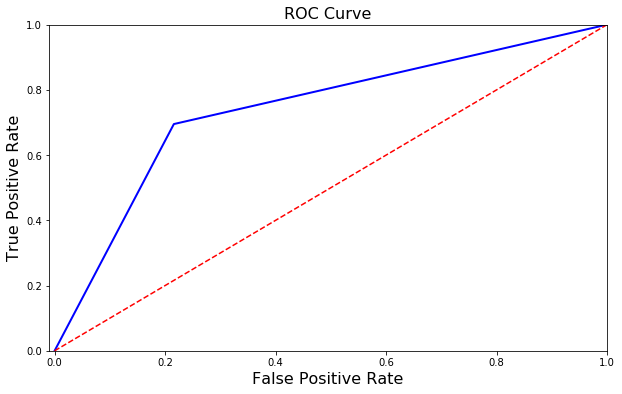

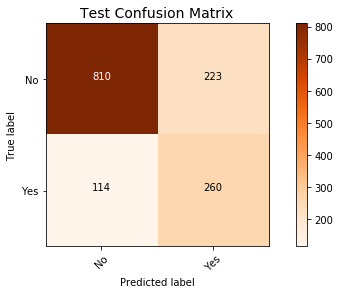

In [24]:
from helper_functions_comprehensive import custom_classification_metrics_function

custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [25]:
from helper_functions_comprehensive import precision_at_recall_threshold_function
predicted_proba = vclf.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(y_test, predicted_proba, 
                                                             recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.4711111111111111


## <a id=6> Conclusion

Notice how the final performance is higher than any of the individual models ! Lets call it a success :)

Note that this is about the same as Day2 when we resampled using SMOTEEN on an untuned RF. This implies there is scope for tuning the hyperparams a bit more. The reader is encouraged to tune

## <a id=7> References